# Install the required libraries

In [ ]:
!pip install transformers --quiet
!pip install wordfreq --quiet
!pip install pqdm --quiet
!pip install swifter --quiet
!pip install datasketch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 8.0 MB/s eta 0:00:00


In [ ]:
%run "/content/drive/MyDrive/Colab Notebooks/utilities_general.py"

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import swifter

from wordfreq import top_n_list, zipf_frequency
import pickle

from tqdm.auto import tqdm
import pandas as pd

import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F


import datasketch
from datasketch import MinHash, MinHashLSH


In [ ]:
path_prefix = "/content/drive/MyDrive/Colab Notebooks/MachineLearning_Fermibot_DimensionalityReduction"
top_n = 4096

In [ ]:
model_name = "deepseek-ai/deepseek-coder-1.3b-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

print(f"DeepSeek-Coder model '{model_name}' and tokenizer loaded.")

In [ ]:
top_words = top_n_list("en", top_n)
df_embeddings = pd.DataFrame({"words": top_words})


def embed_word(word):
    inputs = tokenizer(word, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        return outputs.hidden_states[-1].mean(dim=1).squeeze().numpy()


embeddings_file_path = f"{path_prefix}/df_embeddings.pkl"

df_embeddings["embeddings"] = df_embeddings["words"].swifter.apply(embed_word)
df_embeddings.to_pickle(embeddings_file_path)

df_embeddings = pd.read_pickle(embeddings_file_path).head(512)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 2),
            nn.ReLU(True),
            nn.Linear(encoding_dim * 2, encoding_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim * 2),
            nn.ReLU(True),
            nn.Linear(encoding_dim * 2, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(VariationalAutoencoder, self).__init__()

        # Encoder layers
        self.enc1 = nn.Linear(input_dim, 1024)
        self.enc2 = nn.Linear(1024, 512)
        self.enc3 = nn.Linear(512, 256)

        # Latent space parameters
        self.fc_mu = nn.Linear(256, encoding_dim)
        self.fc_logvar = nn.Linear(256, encoding_dim)

        # Decoder layers
        self.dec1 = nn.Linear(encoding_dim, 256)
        self.dec2 = nn.Linear(256, 512)
        self.dec3 = nn.Linear(512, 1024)
        self.dec4 = nn.Linear(1024, input_dim)

        # Normalization layers
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(256)
        self.bn5 = nn.BatchNorm1d(512)
        self.bn6 = nn.BatchNorm1d(1024)

    def encode(self, x):
        h = F.leaky_relu(self.bn1(self.enc1(x)), 0.2)
        h = F.leaky_relu(self.bn2(self.enc2(h)), 0.2)
        h = F.leaky_relu(self.bn3(self.enc3(h)), 0.2)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        h = F.leaky_relu(self.bn4(self.dec1(z)), 0.2)
        h = F.leaky_relu(self.bn5(self.dec2(h)), 0.2)
        h = F.leaky_relu(self.bn6(self.dec3(h)), 0.2)
        return self.dec4(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z)

In [ ]:
model = Autoencoder(2048, 64)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.5 MB/s eta 0:00:00


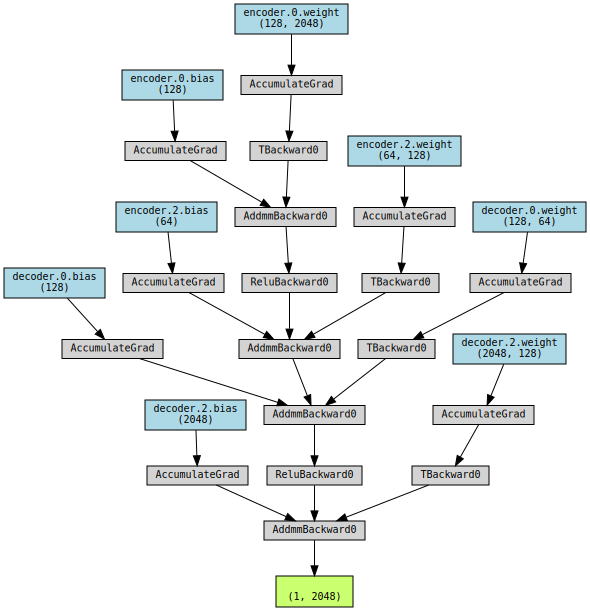

In [ ]:
# prompt: show the model flow in a graph

!pip install torchviz --quiet
from torchviz import make_dot

# Assuming you have an input tensor 'x' that the model expects
# For Autoencoder, x should have the shape (batch_size, input_dim)
# Let's create a dummy input based on the initialized Autoencoder
dummy_input = torch.randn(1, 2048)

# Generate the graph
graph = make_dot(model(dummy_input), params=dict(model.named_parameters()))

# Display the graph
graph


In [ ]:
# prompt: update the below code with a stopping criterion depending on the rate of change of loss

# Assuming 'df_embeddings' is loaded and contains a column 'embeddings'
# Prepare data
X = np.stack(df_embeddings['embeddings'].values)
X_tensor = torch.FloatTensor(X)

# Split data
X_train, X_test = train_test_split(X_tensor, test_size=0.2, random_state=42)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


for endoding_dim_var in [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:

  # Model, Loss, and Optimizer
  input_dim = X_train.shape[1]
  encoding_dim = endoding_dim_var # Example encoding dimension, adjust as needed
  model = Autoencoder(input_dim, encoding_dim)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Training loop with early stopping
  num_epochs = 1000 # Set a high number of epochs, early stopping will handle termination
  patience = 10 # Number of epochs to wait for improvement
  min_delta = 1e-4 # Minimum change to be considered an improvement

  best_loss = float('inf')
  epochs_no_improve = 0
  history = {'train_loss': [], 'test_loss': []}

  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      for data in train_loader:
          inputs = data[0]
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, inputs)
          loss.backward()
          optimizer.step()
          running_loss += loss.item() * inputs.size(0)

      epoch_train_loss = running_loss / len(train_loader.dataset)
      history['train_loss'].append(epoch_train_loss)

      # Evaluate on test set
      model.eval()
      running_test_loss = 0.0
      with torch.no_grad():
          for data in test_loader:
              inputs = data[0]
              outputs = model(inputs)
              loss = criterion(outputs, inputs)
              running_test_loss += loss.item() * inputs.size(0)

      epoch_test_loss = running_test_loss / len(test_loader.dataset)
      history['test_loss'].append(epoch_test_loss)

      print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

      # Check for early stopping
      if epoch_test_loss < best_loss - min_delta:
          best_loss = epoch_test_loss
          epochs_no_improve = 0
          # Optionally save the best model state
          # torch.save(model.state_dict(), 'best_model.pth')
      else:
          epochs_no_improve += 1
          if epochs_no_improve >= patience:
              print(f'Early stopping triggered after {epoch+1} epochs due to no improvement in test loss.')
              break

  print('Training finished.')


  # prompt: use the above model to encode all the embeddings to the lower dimensions
  # Encode all embeddings using the trained encoder

  # Stack the numpy arrays in the 'embeddings' column into a single numpy array
  embeddings_np = np.stack(df_embeddings["embeddings"].to_numpy())

  # Convert the numpy array to a PyTorch tensor
  embeddings_tensor = torch.FloatTensor(embeddings_np)

  model.eval()

  with torch.no_grad():
      # Get distribution parameters
      mu = model.encoder(embeddings_tensor)

      # Option 1: Use mean vector (deterministic)
      encoded_embeddings = mu.cpu().numpy()

  print_formatter(f"All embeddings encoded to lower dimensions|End|Dim: {encoded_embeddings.shape}", color="green")

  # You can now use encoded_embeddings for further tasks
  # For example, adding them to the DataFrame:
  df_embeddings[f'embeddings_ae_{endoding_dim_var:04}'] = [x for x in encoded_embeddings]

  print_formatter(f"Encoded embeddings added to DataFrame|End|Dim: {df_embeddings.shape}", color="green")
  display(df_embeddings.head())


Epoch [1/1000], Train Loss: 0.1217, Test Loss: 0.1178
Epoch [2/1000], Train Loss: 0.1135, Test Loss: 0.1109
Epoch [3/1000], Train Loss: 0.1065, Test Loss: 0.1037
Epoch [4/1000], Train Loss: 0.0992, Test Loss: 0.0959
Epoch [5/1000], Train Loss: 0.0910, Test Loss: 0.0873
Epoch [6/1000], Train Loss: 0.0822, Test Loss: 0.0783
Epoch [7/1000], Train Loss: 0.0732, Test Loss: 0.0694
Epoch [8/1000], Train Loss: 0.0646, Test Loss: 0.0611
Epoch [9/1000], Train Loss: 0.0567, Test Loss: 0.0536
Epoch [10/1000], Train Loss: 0.0498, Test Loss: 0.0470
Epoch [11/1000], Train Loss: 0.0437, Test Loss: 0.0413
Epoch [12/1000], Train Loss: 0.0386, Test Loss: 0.0365
Epoch [13/1000], Train Loss: 0.0342, Test Loss: 0.0325
Epoch [14/1000], Train Loss: 0.0306, Test Loss: 0.0291
Epoch [15/1000], Train Loss: 0.0276, Test Loss: 0.0263
Epoch [16/1000], Train Loss: 0.0251, Test Loss: 0.0241
Epoch [17/1000], Train Loss: 0.0231, Test Loss: 0.0222
Epoch [18/1000], Train Loss: 0.0215, Test Loss: 0.0207
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]"
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]"
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]"
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]"
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]"


Epoch [1/1000], Train Loss: 0.0818, Test Loss: 0.0793
Epoch [2/1000], Train Loss: 0.0761, Test Loss: 0.0743
Epoch [3/1000], Train Loss: 0.0713, Test Loss: 0.0696
Epoch [4/1000], Train Loss: 0.0668, Test Loss: 0.0652
Epoch [5/1000], Train Loss: 0.0624, Test Loss: 0.0608
Epoch [6/1000], Train Loss: 0.0582, Test Loss: 0.0566
Epoch [7/1000], Train Loss: 0.0541, Test Loss: 0.0526
Epoch [8/1000], Train Loss: 0.0502, Test Loss: 0.0487
Epoch [9/1000], Train Loss: 0.0465, Test Loss: 0.0450
Epoch [10/1000], Train Loss: 0.0429, Test Loss: 0.0415
Epoch [11/1000], Train Loss: 0.0396, Test Loss: 0.0383
Epoch [12/1000], Train Loss: 0.0366, Test Loss: 0.0353
Epoch [13/1000], Train Loss: 0.0338, Test Loss: 0.0325
Epoch [14/1000], Train Loss: 0.0311, Test Loss: 0.0297
Epoch [15/1000], Train Loss: 0.0284, Test Loss: 0.0270
Epoch [16/1000], Train Loss: 0.0258, Test Loss: 0.0245
Epoch [17/1000], Train Loss: 0.0237, Test Loss: 0.0224
Epoch [18/1000], Train Loss: 0.0219, Test Loss: 0.0208
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]"
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]"
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398..."
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.020581067, 0.51101834, 0.25108..."


Epoch [1/1000], Train Loss: 0.0606, Test Loss: 0.0580
Epoch [2/1000], Train Loss: 0.0550, Test Loss: 0.0533
Epoch [3/1000], Train Loss: 0.0503, Test Loss: 0.0484
Epoch [4/1000], Train Loss: 0.0455, Test Loss: 0.0433
Epoch [5/1000], Train Loss: 0.0405, Test Loss: 0.0382
Epoch [6/1000], Train Loss: 0.0355, Test Loss: 0.0331
Epoch [7/1000], Train Loss: 0.0308, Test Loss: 0.0285
Epoch [8/1000], Train Loss: 0.0268, Test Loss: 0.0248
Epoch [9/1000], Train Loss: 0.0236, Test Loss: 0.0218
Epoch [10/1000], Train Loss: 0.0211, Test Loss: 0.0196
Epoch [11/1000], Train Loss: 0.0192, Test Loss: 0.0180
Epoch [12/1000], Train Loss: 0.0178, Test Loss: 0.0167
Epoch [13/1000], Train Loss: 0.0167, Test Loss: 0.0158
Epoch [14/1000], Train Loss: 0.0158, Test Loss: 0.0149
Epoch [15/1000], Train Loss: 0.0149, Test Loss: 0.0141
Epoch [16/1000], Train Loss: 0.0141, Test Loss: 0.0134
Epoch [17/1000], Train Loss: 0.0134, Test Loss: 0.0127
Epoch [18/1000], Train Loss: 0.0127, Test Loss: 0.0121
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362..."
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.020581067, 0.51101834, 0.25108...","[0.29702687, -0.8301324, -0.04182321, -0.35489..."


Epoch [1/1000], Train Loss: 0.0511, Test Loss: 0.0476
Epoch [2/1000], Train Loss: 0.0426, Test Loss: 0.0370
Epoch [3/1000], Train Loss: 0.0316, Test Loss: 0.0260
Epoch [4/1000], Train Loss: 0.0227, Test Loss: 0.0193
Epoch [5/1000], Train Loss: 0.0181, Test Loss: 0.0162
Epoch [6/1000], Train Loss: 0.0158, Test Loss: 0.0144
Epoch [7/1000], Train Loss: 0.0143, Test Loss: 0.0132
Epoch [8/1000], Train Loss: 0.0133, Test Loss: 0.0124
Epoch [9/1000], Train Loss: 0.0126, Test Loss: 0.0118
Epoch [10/1000], Train Loss: 0.0120, Test Loss: 0.0113
Epoch [11/1000], Train Loss: 0.0116, Test Loss: 0.0110
Epoch [12/1000], Train Loss: 0.0113, Test Loss: 0.0108
Epoch [13/1000], Train Loss: 0.0111, Test Loss: 0.0106
Epoch [14/1000], Train Loss: 0.0109, Test Loss: 0.0105
Epoch [15/1000], Train Loss: 0.0108, Test Loss: 0.0104
Epoch [16/1000], Train Loss: 0.0107, Test Loss: 0.0104
Epoch [17/1000], Train Loss: 0.0107, Test Loss: 0.0103
Epoch [18/1000], Train Loss: 0.0106, Test Loss: 0.0103
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512..."
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.020581067, 0.51101834, 0.25108...","[0.29702687, -0.8301324, -0.04182321, -0.35489...","[0.2579102, -1.3516138, 0.36592066, 0.22639519..."


Epoch [1/1000], Train Loss: 0.0415, Test Loss: 0.0344
Epoch [2/1000], Train Loss: 0.0279, Test Loss: 0.0220
Epoch [3/1000], Train Loss: 0.0197, Test Loss: 0.0170
Epoch [4/1000], Train Loss: 0.0161, Test Loss: 0.0141
Epoch [5/1000], Train Loss: 0.0136, Test Loss: 0.0121
Epoch [6/1000], Train Loss: 0.0120, Test Loss: 0.0111
Epoch [7/1000], Train Loss: 0.0112, Test Loss: 0.0106
Epoch [8/1000], Train Loss: 0.0108, Test Loss: 0.0104
Epoch [9/1000], Train Loss: 0.0106, Test Loss: 0.0102
Epoch [10/1000], Train Loss: 0.0105, Test Loss: 0.0101
Epoch [11/1000], Train Loss: 0.0103, Test Loss: 0.0100
Epoch [12/1000], Train Loss: 0.0102, Test Loss: 0.0099
Epoch [13/1000], Train Loss: 0.0100, Test Loss: 0.0098
Epoch [14/1000], Train Loss: 0.0099, Test Loss: 0.0097
Epoch [15/1000], Train Loss: 0.0098, Test Loss: 0.0096
Epoch [16/1000], Train Loss: 0.0097, Test Loss: 0.0095
Epoch [17/1000], Train Loss: 0.0096, Test Loss: 0.0095
Epoch [18/1000], Train Loss: 0.0096, Test Loss: 0.0094
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612..."
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.020581067, 0.51101834, 0.25108...","[0.29702687, -0.8301324, -0.04182321, -0.35489...","[0.2579102, -1.3516138, 0.36592066, 0.22639519...","[0.11467886, 0.41805094, 0.23227218, -0.031175..."


Epoch [1/1000], Train Loss: 0.0350, Test Loss: 0.0227
Epoch [2/1000], Train Loss: 0.0186, Test Loss: 0.0151
Epoch [3/1000], Train Loss: 0.0136, Test Loss: 0.0118
Epoch [4/1000], Train Loss: 0.0114, Test Loss: 0.0106
Epoch [5/1000], Train Loss: 0.0108, Test Loss: 0.0103
Epoch [6/1000], Train Loss: 0.0104, Test Loss: 0.0100
Epoch [7/1000], Train Loss: 0.0101, Test Loss: 0.0097
Epoch [8/1000], Train Loss: 0.0098, Test Loss: 0.0096
Epoch [9/1000], Train Loss: 0.0096, Test Loss: 0.0094
Epoch [10/1000], Train Loss: 0.0094, Test Loss: 0.0093
Epoch [11/1000], Train Loss: 0.0093, Test Loss: 0.0091
Epoch [12/1000], Train Loss: 0.0091, Test Loss: 0.0090
Epoch [13/1000], Train Loss: 0.0090, Test Loss: 0.0089
Epoch [14/1000], Train Loss: 0.0088, Test Loss: 0.0088
Epoch [15/1000], Train Loss: 0.0087, Test Loss: 0.0087
Epoch [16/1000], Train Loss: 0.0085, Test Loss: 0.0086
Epoch [17/1000], Train Loss: 0.0084, Test Loss: 0.0085
Epoch [18/1000], Train Loss: 0.0083, Test Loss: 0.0084
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209..."
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.020581067, 0.51101834, 0.25108...","[0.29702687, -0.8301324, -0.04182321, -0.35489...","[0.2579102, -1.3516138, 0.36592066, 0.22639519...","[0.11467886, 0.41805094, 0.23227218, -0.031175...","[0.056621782, 0.100334585, -0.06285103, 0.5869..."


Epoch [1/1000], Train Loss: 0.0281, Test Loss: 0.0166
Epoch [2/1000], Train Loss: 0.0141, Test Loss: 0.0117
Epoch [3/1000], Train Loss: 0.0113, Test Loss: 0.0105
Epoch [4/1000], Train Loss: 0.0105, Test Loss: 0.0101
Epoch [5/1000], Train Loss: 0.0101, Test Loss: 0.0097
Epoch [6/1000], Train Loss: 0.0097, Test Loss: 0.0094
Epoch [7/1000], Train Loss: 0.0094, Test Loss: 0.0092
Epoch [8/1000], Train Loss: 0.0091, Test Loss: 0.0090
Epoch [9/1000], Train Loss: 0.0088, Test Loss: 0.0088
Epoch [10/1000], Train Loss: 0.0086, Test Loss: 0.0086
Epoch [11/1000], Train Loss: 0.0083, Test Loss: 0.0084
Epoch [12/1000], Train Loss: 0.0081, Test Loss: 0.0082
Epoch [13/1000], Train Loss: 0.0078, Test Loss: 0.0081
Epoch [14/1000], Train Loss: 0.0076, Test Loss: 0.0079
Epoch [15/1000], Train Loss: 0.0074, Test Loss: 0.0079
Epoch [16/1000], Train Loss: 0.0073, Test Loss: 0.0077
Epoch [17/1000], Train Loss: 0.0071, Test Loss: 0.0076
Epoch [18/1000], Train Loss: 0.0069, Test Loss: 0.0075
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575..."
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.020581067, 0.51101834, 0.25108...","[0.29702687, -0.8301324, -0.04182321, -0.35489...","[0.2579102, -1.3516138, 0.36592066, 0.22639519...","[0.11467886, 0.41805094, 0.23227218, -0.031175...","[0.056621782, 0.100334585, -0.06285103, 0.5869...","[-0.2758536, 0.3306392, -0.26264098, 0.2426348..."


Epoch [1/1000], Train Loss: 0.0223, Test Loss: 0.0127
Epoch [2/1000], Train Loss: 0.0117, Test Loss: 0.0107
Epoch [3/1000], Train Loss: 0.0106, Test Loss: 0.0100
Epoch [4/1000], Train Loss: 0.0100, Test Loss: 0.0095
Epoch [5/1000], Train Loss: 0.0095, Test Loss: 0.0092
Epoch [6/1000], Train Loss: 0.0091, Test Loss: 0.0089
Epoch [7/1000], Train Loss: 0.0087, Test Loss: 0.0087
Epoch [8/1000], Train Loss: 0.0083, Test Loss: 0.0084
Epoch [9/1000], Train Loss: 0.0080, Test Loss: 0.0081
Epoch [10/1000], Train Loss: 0.0076, Test Loss: 0.0079
Epoch [11/1000], Train Loss: 0.0073, Test Loss: 0.0077
Epoch [12/1000], Train Loss: 0.0070, Test Loss: 0.0076
Epoch [13/1000], Train Loss: 0.0067, Test Loss: 0.0074
Epoch [14/1000], Train Loss: 0.0065, Test Loss: 0.0073
Epoch [15/1000], Train Loss: 0.0062, Test Loss: 0.0072
Epoch [16/1000], Train Loss: 0.0060, Test Loss: 0.0071
Epoch [17/1000], Train Loss: 0.0057, Test Loss: 0.0071
Epoch [18/1000], Train Loss: 0.0055, Test Loss: 0.0073
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128,embeddings_ae_0256
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224...","[-0.14625293, 0.050695583, 0.1358188, -0.25103..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431...","[0.0667065, -0.04204256, -0.3162315, -0.109131..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478...","[-0.18232271, 0.054953933, -0.17992876, -0.248..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575...","[-0.25670385, 0.3462012, 0.37846583, 0.3066149..."
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.020581067, 0.51101834, 0.25108...","[0.29702687, -0.8301324, -0.04182321, -0.35489...","[0.2579102, -1.3516138, 0.36592066, 0.22639519...","[0.11467886, 0.41805094, 0.23227218, -0.031175...","[0.056621782, 0.100334585, -0.06285103, 0.5869...","[-0.2758536, 0.3306392, -0.26264098, 0.2426348...","[-0.02320751, -0.14586945, -0.05030622, -0.280..."


Epoch [1/1000], Train Loss: 0.0237, Test Loss: 0.0138
Epoch [2/1000], Train Loss: 0.0120, Test Loss: 0.0107
Epoch [3/1000], Train Loss: 0.0107, Test Loss: 0.0102
Epoch [4/1000], Train Loss: 0.0102, Test Loss: 0.0097
Epoch [5/1000], Train Loss: 0.0097, Test Loss: 0.0094
Epoch [6/1000], Train Loss: 0.0095, Test Loss: 0.0094
Epoch [7/1000], Train Loss: 0.0093, Test Loss: 0.0091
Epoch [8/1000], Train Loss: 0.0089, Test Loss: 0.0089
Epoch [9/1000], Train Loss: 0.0086, Test Loss: 0.0086
Epoch [10/1000], Train Loss: 0.0083, Test Loss: 0.0084
Epoch [11/1000], Train Loss: 0.0079, Test Loss: 0.0081
Epoch [12/1000], Train Loss: 0.0075, Test Loss: 0.0078
Epoch [13/1000], Train Loss: 0.0072, Test Loss: 0.0077
Epoch [14/1000], Train Loss: 0.0069, Test Loss: 0.0077
Epoch [15/1000], Train Loss: 0.0067, Test Loss: 0.0075
Epoch [16/1000], Train Loss: 0.0064, Test Loss: 0.0074
Epoch [17/1000], Train Loss: 0.0061, Test Loss: 0.0073
Epoch [18/1000], Train Loss: 0.0058, Test Loss: 0.0072
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128,embeddings_ae_0256,embeddings_ae_0512
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224...","[-0.14625293, 0.050695583, 0.1358188, -0.25103...","[0.035594523, 0.20097399, 0.06715294, -0.12918..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431...","[0.0667065, -0.04204256, -0.3162315, -0.109131...","[-0.13094234, 0.114521325, 0.17742744, -0.0818..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478...","[-0.18232271, 0.054953933, -0.17992876, -0.248...","[0.049507048, -0.10480355, -0.02501653, 0.0124..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575...","[-0.25670385, 0.3462012, 0.37846583, 0.3066149...","[-0.09429362, -0.3466875, 0.24541146, 0.053519..."
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.020581067, 0.51101834, 0.25108...","[0.29702687, -0.8301324, -0.04182321, -0.35489...","[0.2579102, -1.3516138, 0.36592066, 0.22639519...","[0.11467886, 0.41805094, 0.23227218, -0.031175...","[0.056621782, 0.100334585, -0.06285103, 0.5869...","[-0.2758536, 0.3306392, -0.26264098, 0.2426348...","[-0.02320751, -0.14586945, -0.05030622, -0.280...","[0.302162, 0.108380795, 0.047957785, -0.182940..."


Epoch [1/1000], Train Loss: 0.0224, Test Loss: 0.0130
Epoch [2/1000], Train Loss: 0.0118, Test Loss: 0.0107
Epoch [3/1000], Train Loss: 0.0108, Test Loss: 0.0102
Epoch [4/1000], Train Loss: 0.0102, Test Loss: 0.0096
Epoch [5/1000], Train Loss: 0.0097, Test Loss: 0.0095
Epoch [6/1000], Train Loss: 0.0095, Test Loss: 0.0094
Epoch [7/1000], Train Loss: 0.0093, Test Loss: 0.0092
Epoch [8/1000], Train Loss: 0.0091, Test Loss: 0.0090
Epoch [9/1000], Train Loss: 0.0088, Test Loss: 0.0088
Epoch [10/1000], Train Loss: 0.0085, Test Loss: 0.0086
Epoch [11/1000], Train Loss: 0.0082, Test Loss: 0.0084
Epoch [12/1000], Train Loss: 0.0079, Test Loss: 0.0081
Epoch [13/1000], Train Loss: 0.0076, Test Loss: 0.0079
Epoch [14/1000], Train Loss: 0.0073, Test Loss: 0.0078
Epoch [15/1000], Train Loss: 0.0070, Test Loss: 0.0079
Epoch [16/1000], Train Loss: 0.0070, Test Loss: 0.0076
Epoch [17/1000], Train Loss: 0.0067, Test Loss: 0.0076
Epoch [18/1000], Train Loss: 0.0064, Test Loss: 0.0075
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128,embeddings_ae_0256,embeddings_ae_0512,embeddings_ae_1024
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224...","[-0.14625293, 0.050695583, 0.1358188, -0.25103...","[0.035594523, 0.20097399, 0.06715294, -0.12918...","[0.029023938, -0.0043886844, 0.15068448, -0.09..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431...","[0.0667065, -0.04204256, -0.3162315, -0.109131...","[-0.13094234, 0.114521325, 0.17742744, -0.0818...","[0.014028318, 0.04241609, 0.15403542, -0.14518..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478...","[-0.18232271, 0.054953933, -0.17992876, -0.248...","[0.049507048, -0.10480355, -0.02501653, 0.0124...","[-0.033299383, 0.061106317, 0.09202761, -0.012..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575...","[-0.25670385, 0.3462012, 0.37846583, 0.3066149...","[-0.09429362, -0.3466875, 0.24541146, 0.053519...","[-0.111416735, -0.17806692, -0.019681104, 0.03..."
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.020581067, 0.51101834, 0.25108...","[0.29702687, -0.8301324, -0.04182321, -0.35489...","[0.2579102, -1.3516138, 0.36592066, 0.22639519...","[0.11467886, 0.41805094, 0.23227218, -0.031175...","[0.056621782, 0.100334585, -0.06285103, 0.5869...","[-0.2758536, 0.3306392, -0.26264098, 0.2426348...","[-0.02320751, -0.14586945, -0.05030622, -0.280...","[0.302162, 0.108380795, 0.047957785, -0.182940...","[-0.042931337, 0.26134777, 0.22309795, -0.0895..."


In [ ]:
# prompt: update the below code with a stopping criterion depending on the rate of change of loss

# Assuming 'df_embeddings' is loaded and contains a column 'embeddings'
# Prepare data
X = np.stack(df_embeddings['embeddings'].values)
X_tensor = torch.FloatTensor(X)

# Split data
X_train, X_test = train_test_split(X_tensor, test_size=0.2, random_state=42)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


for endoding_dim_var in [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:

  # Model, Loss, and Optimizer
  input_dim = X_train.shape[1]
  encoding_dim = endoding_dim_var # Example encoding dimension, adjust as needed
  model = VariationalAutoencoder(input_dim, encoding_dim)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Training loop with early stopping
  num_epochs = 1000 # Set a high number of epochs, early stopping will handle termination
  patience = 10 # Number of epochs to wait for improvement
  min_delta = 1e-4 # Minimum change to be considered an improvement

  best_loss = float('inf')
  epochs_no_improve = 0
  history = {'train_loss': [], 'test_loss': []}

  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      for data in train_loader:
          inputs = data[0]
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, inputs)
          loss.backward()
          optimizer.step()
          running_loss += loss.item() * inputs.size(0)

      epoch_train_loss = running_loss / len(train_loader.dataset)
      history['train_loss'].append(epoch_train_loss)

      # Evaluate on test set
      model.eval()
      running_test_loss = 0.0
      with torch.no_grad():
          for data in test_loader:
              inputs = data[0]
              outputs = model(inputs)
              loss = criterion(outputs, inputs)
              running_test_loss += loss.item() * inputs.size(0)

      epoch_test_loss = running_test_loss / len(test_loader.dataset)
      history['test_loss'].append(epoch_test_loss)

      print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

      # Check for early stopping
      if epoch_test_loss < best_loss - min_delta:
          best_loss = epoch_test_loss
          epochs_no_improve = 0
          # Optionally save the best model state
          # torch.save(model.state_dict(), 'best_model.pth')
      else:
          epochs_no_improve += 1
          if epochs_no_improve >= patience:
              print(f'Early stopping triggered after {epoch+1} epochs due to no improvement in test loss.')
              break

  print('Training finished.')


  # prompt: use the above model to encode all the embeddings to the lower dimensions
  # Encode all embeddings using the trained encoder

  # Stack the numpy arrays in the 'embeddings' column into a single numpy array
  embeddings_np = np.stack(df_embeddings["embeddings"].to_numpy())

  # Convert the numpy array to a PyTorch tensor
  embeddings_tensor = torch.FloatTensor(embeddings_np)

  model.eval()

  with torch.no_grad():
      # Get distribution parameters
      mu, logvar = model.encode(embeddings_tensor)

      # Option 1: Use mean vector (deterministic)
      encoded_embeddings = mu.cpu().numpy()

  print_formatter(f"All embeddings encoded to lower dimensions|End|Dim: {encoded_embeddings.shape}", color="green")

  # You can now use encoded_embeddings for further tasks
  # For example, adding them to the DataFrame:
  df_embeddings[f'embeddings_vae_{endoding_dim_var:04}'] = [x for x in encoded_embeddings]

  print_formatter(f"Encoded embeddings added to DataFrame|End|Dim: {df_embeddings.shape}", color="green")
  display(df_embeddings.head())


Epoch [1/1000], Train Loss: 0.0638, Test Loss: 0.0198
Epoch [2/1000], Train Loss: 0.0210, Test Loss: 0.0161
Epoch [3/1000], Train Loss: 0.0158, Test Loss: 0.0135
Epoch [4/1000], Train Loss: 0.0140, Test Loss: 0.0125
Epoch [5/1000], Train Loss: 0.0131, Test Loss: 0.0119
Epoch [6/1000], Train Loss: 0.0130, Test Loss: 0.0114
Epoch [7/1000], Train Loss: 0.0131, Test Loss: 0.0118
Epoch [8/1000], Train Loss: 0.0127, Test Loss: 0.0115
Epoch [9/1000], Train Loss: 0.0126, Test Loss: 0.0116
Epoch [10/1000], Train Loss: 0.0128, Test Loss: 0.0118
Epoch [11/1000], Train Loss: 0.0125, Test Loss: 0.0121
Epoch [12/1000], Train Loss: 0.0130, Test Loss: 0.0120
Epoch [13/1000], Train Loss: 0.0125, Test Loss: 0.0111
Epoch [14/1000], Train Loss: 0.0125, Test Loss: 0.0115
Epoch [15/1000], Train Loss: 0.0121, Test Loss: 0.0110
Epoch [16/1000], Train Loss: 0.0125, Test Loss: 0.0113
Epoch [17/1000], Train Loss: 0.0118, Test Loss: 0.0115
Epoch [18/1000], Train Loss: 0.0120, Test Loss: 0.0111
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128,embeddings_ae_0256,embeddings_ae_0512,embeddings_ae_1024,embeddings_vae_0002
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224...","[-0.14625293, 0.050695583, 0.1358188, -0.25103...","[0.035594523, 0.20097399, 0.06715294, -0.12918...","[0.029023938, -0.0043886844, 0.15068448, -0.09...","[0.08816154, 1.0120077]"
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431...","[0.0667065, -0.04204256, -0.3162315, -0.109131...","[-0.13094234, 0.114521325, 0.17742744, -0.0818...","[0.014028318, 0.04241609, 0.15403542, -0.14518...","[-0.27539665, 0.081111774]"
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478...","[-0.18232271, 0.054953933, -0.17992876, -0.248...","[0.049507048, -0.10480355, -0.02501653, 0.0124...","[-0.033299383, 0.061106317, 0.09202761, -0.012...","[-3.066338, -1.5809311]"
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575...","[-0.25670385, 0.3462012, 0.37846583, 0.3066149...","[-0.09429362, -0.3466875, 0.24541146, 0.053519...","[-0.111416735, -0.17806692, -0.019681104, 0.03...","[0.89995444, -0.46409395]"
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.020581067, 0.51101834, 0.25108...","[0.29702687, -0.8301324, -0.04182321, -0.35489...","[0.2579102, -1.3516138, 0.36592066, 0.22639519...","[0.11467886, 0.41805094, 0.23227218, -0.031175...","[0.056621782, 0.100334585, -0.06285103, 0.5869...","[-0.2758536, 0.3306392, -0.26264098, 0.2426348...","[-0.02320751, -0.14586945, -0.05030622, -0.280...","[0.302162, 0.108380795, 0.047957785, -0.182940...","[-0.042931337, 0.26134777, 0.22309795, -0.0895...","[1.6978228, 2.2767777]"


Epoch [1/1000], Train Loss: 0.0672, Test Loss: 0.0191
Epoch [2/1000], Train Loss: 0.0212, Test Loss: 0.0157
Epoch [3/1000], Train Loss: 0.0153, Test Loss: 0.0133
Epoch [4/1000], Train Loss: 0.0133, Test Loss: 0.0118
Epoch [5/1000], Train Loss: 0.0133, Test Loss: 0.0113
Epoch [6/1000], Train Loss: 0.0131, Test Loss: 0.0114
Epoch [7/1000], Train Loss: 0.0126, Test Loss: 0.0109
Epoch [8/1000], Train Loss: 0.0122, Test Loss: 0.0107
Epoch [9/1000], Train Loss: 0.0122, Test Loss: 0.0107
Epoch [10/1000], Train Loss: 0.0120, Test Loss: 0.0109
Epoch [11/1000], Train Loss: 0.0120, Test Loss: 0.0107
Epoch [12/1000], Train Loss: 0.0117, Test Loss: 0.0107
Epoch [13/1000], Train Loss: 0.0116, Test Loss: 0.0105
Epoch [14/1000], Train Loss: 0.0114, Test Loss: 0.0106
Epoch [15/1000], Train Loss: 0.0117, Test Loss: 0.0106
Epoch [16/1000], Train Loss: 0.0121, Test Loss: 0.0114
Epoch [17/1000], Train Loss: 0.0118, Test Loss: 0.0107
Epoch [18/1000], Train Loss: 0.0115, Test Loss: 0.0107
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128,embeddings_ae_0256,embeddings_ae_0512,embeddings_ae_1024,embeddings_vae_0002,embeddings_vae_0004
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224...","[-0.14625293, 0.050695583, 0.1358188, -0.25103...","[0.035594523, 0.20097399, 0.06715294, -0.12918...","[0.029023938, -0.0043886844, 0.15068448, -0.09...","[0.08816154, 1.0120077]","[-0.98706543, 1.368107, -0.52076477, -1.077011]"
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431...","[0.0667065, -0.04204256, -0.3162315, -0.109131...","[-0.13094234, 0.114521325, 0.17742744, -0.0818...","[0.014028318, 0.04241609, 0.15403542, -0.14518...","[-0.27539665, 0.081111774]","[-0.57393146, 0.38086522, 1.2679826, 1.3618102]"
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478...","[-0.18232271, 0.054953933, -0.17992876, -0.248...","[0.049507048, -0.10480355, -0.02501653, 0.0124...","[-0.033299383, 0.061106317, 0.09202761, -0.012...","[-3.066338, -1.5809311]","[-0.14872575, -0.48192245, 3.8976872, -0.9497539]"
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575...","[-0.25670385, 0.3462012, 0.37846583, 0.3066149...","[-0.09429362, -0.3466875, 0.24541146, 0.053519...","[-0.111416735, -0.17806692, -0.019681104, 0.03...","[0.89995444, -0.46409395]","[0.062780365, 0.8287962, -0.58464324, -0.6542219]"
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.020581067, 0.51101834, 0.25108...","[0.29702687, -0.8301324, -0.04182321, -0.35489...","[0.2579102, -1.3516138, 0.36592066, 0.22639519...","[0.11467886, 0.41805094, 0.23227218, -0.031175...","[0.056621782, 0.100334585, -0.06285103, 0.5869...","[-0.2758536, 0.3306392, -0.26264098, 0.2426348...","[-0.02320751, -0.14586945, -0.05030622, -0.280...","[0.302162, 0.108380795, 0.047957785, -0.182940...","[-0.042931337, 0.26134777, 0.22309795, -0.0895...","[1.6978228, 2.2767777]","[-0.65698487, 0.6789176, -0.74666345, 2.8262992]"


Epoch [1/1000], Train Loss: 0.0751, Test Loss: 0.0194
Epoch [2/1000], Train Loss: 0.0239, Test Loss: 0.0171
Epoch [3/1000], Train Loss: 0.0151, Test Loss: 0.0139
Epoch [4/1000], Train Loss: 0.0134, Test Loss: 0.0119
Epoch [5/1000], Train Loss: 0.0131, Test Loss: 0.0121
Epoch [6/1000], Train Loss: 0.0132, Test Loss: 0.0121
Epoch [7/1000], Train Loss: 0.0134, Test Loss: 0.0114
Epoch [8/1000], Train Loss: 0.0124, Test Loss: 0.0113
Epoch [9/1000], Train Loss: 0.0125, Test Loss: 0.0113
Epoch [10/1000], Train Loss: 0.0125, Test Loss: 0.0111
Epoch [11/1000], Train Loss: 0.0118, Test Loss: 0.0106
Epoch [12/1000], Train Loss: 0.0116, Test Loss: 0.0106
Epoch [13/1000], Train Loss: 0.0115, Test Loss: 0.0112
Epoch [14/1000], Train Loss: 0.0114, Test Loss: 0.0105
Epoch [15/1000], Train Loss: 0.0114, Test Loss: 0.0103
Epoch [16/1000], Train Loss: 0.0113, Test Loss: 0.0104
Epoch [17/1000], Train Loss: 0.0111, Test Loss: 0.0103
Epoch [18/1000], Train Loss: 0.0113, Test Loss: 0.0100
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128,embeddings_ae_0256,embeddings_ae_0512,embeddings_ae_1024,embeddings_vae_0002,embeddings_vae_0004,embeddings_vae_0008
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224...","[-0.14625293, 0.050695583, 0.1358188, -0.25103...","[0.035594523, 0.20097399, 0.06715294, -0.12918...","[0.029023938, -0.0043886844, 0.15068448, -0.09...","[0.08816154, 1.0120077]","[-0.98706543, 1.368107, -0.52076477, -1.077011]","[-1.2293828, -0.07157123, 0.98935646, -1.32889..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431...","[0.0667065, -0.04204256, -0.3162315, -0.109131...","[-0.13094234, 0.114521325, 0.17742744, -0.0818...","[0.014028318, 0.04241609, 0.15403542, -0.14518...","[-0.27539665, 0.081111774]","[-0.57393146, 0.38086522, 1.2679826, 1.3618102]","[1.7593759, -0.46265018, 0.7111835, 0.90114075..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478...","[-0.18232271, 0.054953933, -0.17992876, -0.248...","[0.049507048, -0.10480355, -0.02501653, 0.0124...","[-0.033299383, 0.061106317, 0.09202761, -0.012...","[-3.066338, -1.5809311]","[-0.14872575, -0.48192245, 3.8976872, -0.9497539]","[2.0083578, -1.230723, 0.6472063, -0.64857185,..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575...","[-0.25670385, 0.3462012, 0.37846583, 0.3066149...","[-0.09429362, -0.3466875, 0.24541146, 0.053519...","[-0.111416735, -0.17806692, -0.019681104, 0.03...","[0.89995444, -0.46409395]","[0.062780365, 0.8287962, -0.58464324, -0.6542219]","[3.0238523, 0.46046162, -2.2735574, 0.2438899,..."
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.020581067, 0.51101834, 0.25108...","[0.29702687, -0.8301324, -0.04182321, -0.35489...","[0.2579102, -1.3516138, 0.36592066, 0.22639519...","[0.11467886, 0.41805094, 0.23227218, -0.031175...","[0.056621782, 0.100334585, -0.06285103, 0.5869...","[-0.2758536, 0.3306392, -0.26264098, 0.2426348...","[-0.02320751, -0.14586945, -0.05030622, -0.280...","[0.302162, 0.108380795, 0.047957785, -0.182940...","[-0.042931337, 0.26134777, 0.22309795, -0.0895...","[1.6978228, 2.2767777]","[-0.65698487, 0.6789176, -0.74666345, 2.8262992]","[2.7534225, -1.2918984, 3.188352, 3.7454007, 2..."


Epoch [1/1000], Train Loss: 0.0767, Test Loss: 0.0196
Epoch [2/1000], Train Loss: 0.0218, Test Loss: 0.0228
Epoch [3/1000], Train Loss: 0.0157, Test Loss: 0.0150
Epoch [4/1000], Train Loss: 0.0143, Test Loss: 0.0131
Epoch [5/1000], Train Loss: 0.0153, Test Loss: 0.0122
Epoch [6/1000], Train Loss: 0.0133, Test Loss: 0.0116
Epoch [7/1000], Train Loss: 0.0127, Test Loss: 0.0116
Epoch [8/1000], Train Loss: 0.0124, Test Loss: 0.0106
Epoch [9/1000], Train Loss: 0.0127, Test Loss: 0.0110
Epoch [10/1000], Train Loss: 0.0122, Test Loss: 0.0111
Epoch [11/1000], Train Loss: 0.0124, Test Loss: 0.0107
Epoch [12/1000], Train Loss: 0.0120, Test Loss: 0.0106
Epoch [13/1000], Train Loss: 0.0116, Test Loss: 0.0107
Epoch [14/1000], Train Loss: 0.0118, Test Loss: 0.0109
Epoch [15/1000], Train Loss: 0.0134, Test Loss: 0.0111
Epoch [16/1000], Train Loss: 0.0121, Test Loss: 0.0106
Epoch [17/1000], Train Loss: 0.0116, Test Loss: 0.0108
Epoch [18/1000], Train Loss: 0.0120, Test Loss: 0.0105
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128,embeddings_ae_0256,embeddings_ae_0512,embeddings_ae_1024,embeddings_vae_0002,embeddings_vae_0004,embeddings_vae_0008,embeddings_vae_0016
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224...","[-0.14625293, 0.050695583, 0.1358188, -0.25103...","[0.035594523, 0.20097399, 0.06715294, -0.12918...","[0.029023938, -0.0043886844, 0.15068448, -0.09...","[0.08816154, 1.0120077]","[-0.98706543, 1.368107, -0.52076477, -1.077011]","[-1.2293828, -0.07157123, 0.98935646, -1.32889...","[0.28313485, -0.7126896, 1.7086871, 1.0141199,..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431...","[0.0667065, -0.04204256, -0.3162315, -0.109131...","[-0.13094234, 0.114521325, 0.17742744, -0.0818...","[0.014028318, 0.04241609, 0.15403542, -0.14518...","[-0.27539665, 0.081111774]","[-0.57393146, 0.38086522, 1.2679826, 1.3618102]","[1.7593759, -0.46265018, 0.7111835, 0.90114075...","[0.04532385, -0.88570684, 0.25976047, 0.479137..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478...","[-0.18232271, 0.054953933, -0.17992876, -0.248...","[0.049507048, -0.10480355, -0.02501653, 0.0124...","[-0.033299383, 0.061106317, 0.09202761, -0.012...","[-3.066338, -1.5809311]","[-0.14872575, -0.48192245, 3.8976872, -0.9497539]","[2.0083578, -1.230723, 0.6472063, -0.64857185,...","[1.3589407, 1.4391462, -0.281285, 2.4409664, -..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575...","[-0.25670385, 0.3462012, 0.37846583, 0.3066149...","[-0.09429362, -0.3466875, 0.24541146, 0.053519...","[-0.111416735, -0.17806692, -0.019681104, 0.03...","[0.89995444, -0.46409395]","[0.062780365, 0.8287962, -0.58464324, -0.6542219]","[3.0238523, 0.46046162, -2.2735574, 0.2438899,...","[-3.3922079, 2.8528423, -1.6165441, 0.38126916..."
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.020581067, 0.51101834, 0.25108...","[0.29702687, -0.8301324, -0.04182321, -0.35489...","[0.2579102, -1.3516138, 0.36592066, 0.22639519...","[0.11467886, 0.41805094, 0.23227218, -0.031175...","[0.056621782, 0.100334585, -0.06285103, 0.5869...","[-0.2758536, 0.3306392, -0.26264098, 0.2426348...","[-0.02320751, -0.14586945, -0.05030622, -0.280...","[0.302162, 0.108380795, 0.047957785, -0.182940...","[-0.042931337, 0.26134777, 0.22309795, -0.0895...","[1.6978228, 2.2767777]","[-0.65698487, 0.6789176, -0.74666345, 2.8262992]","[2.7534225, -1.2918984, 3.188352, 3.7454007, 2...","[-1.6719003, -2.6009917, 2.616655, -1.9245706,..."


Epoch [1/1000], Train Loss: 0.0882, Test Loss: 0.0213
Epoch [2/1000], Train Loss: 0.0229, Test Loss: 0.0205
Epoch [3/1000], Train Loss: 0.0158, Test Loss: 0.0139
Epoch [4/1000], Train Loss: 0.0145, Test Loss: 0.0133
Epoch [5/1000], Train Loss: 0.0135, Test Loss: 0.0118
Epoch [6/1000], Train Loss: 0.0138, Test Loss: 0.0117
Epoch [7/1000], Train Loss: 0.0147, Test Loss: 0.0132
Epoch [8/1000], Train Loss: 0.0141, Test Loss: 0.0123
Epoch [9/1000], Train Loss: 0.0136, Test Loss: 0.0110
Epoch [10/1000], Train Loss: 0.0127, Test Loss: 0.0109
Epoch [11/1000], Train Loss: 0.0124, Test Loss: 0.0110
Epoch [12/1000], Train Loss: 0.0128, Test Loss: 0.0110
Epoch [13/1000], Train Loss: 0.0131, Test Loss: 0.0122
Epoch [14/1000], Train Loss: 0.0129, Test Loss: 0.0116
Epoch [15/1000], Train Loss: 0.0126, Test Loss: 0.0114
Epoch [16/1000], Train Loss: 0.0118, Test Loss: 0.0103
Epoch [17/1000], Train Loss: 0.0117, Test Loss: 0.0105
Epoch [18/1000], Train Loss: 0.0116, Test Loss: 0.0102
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128,embeddings_ae_0256,embeddings_ae_0512,embeddings_ae_1024,embeddings_vae_0002,embeddings_vae_0004,embeddings_vae_0008,embeddings_vae_0016,embeddings_vae_0032
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224...","[-0.14625293, 0.050695583, 0.1358188, -0.25103...","[0.035594523, 0.20097399, 0.06715294, -0.12918...","[0.029023938, -0.0043886844, 0.15068448, -0.09...","[0.08816154, 1.0120077]","[-0.98706543, 1.368107, -0.52076477, -1.077011]","[-1.2293828, -0.07157123, 0.98935646, -1.32889...","[0.28313485, -0.7126896, 1.7086871, 1.0141199,...","[-0.7533615, 0.21935043, -0.7475705, 1.1773382..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431...","[0.0667065, -0.04204256, -0.3162315, -0.109131...","[-0.13094234, 0.114521325, 0.17742744, -0.0818...","[0.014028318, 0.04241609, 0.15403542, -0.14518...","[-0.27539665, 0.081111774]","[-0.57393146, 0.38086522, 1.2679826, 1.3618102]","[1.7593759, -0.46265018, 0.7111835, 0.90114075...","[0.04532385, -0.88570684, 0.25976047, 0.479137...","[-0.4423306, -0.6929193, -0.16916367, 0.288992..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478...","[-0.18232271, 0.054953933, -0.17992876, -0.248...","[0.049507048, -0.10480355, -0.02501653, 0.0124...","[-0.033299383, 0.061106317, 0.09202761, -0.012...","[-3.066338, -1.5809311]","[-0.14872575, -0.48192245, 3.8976872, -0.9497539]","[2.0083578, -1.230723, 0.6472063, -0.64857185,...","[1.3589407, 1.4391462, -0.281285, 2.4409664, -...","[-0.152653, 0.37725657, 2.0487542, -1.1137037,..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575...","[-0.25670385, 0.3462012, 0.37846583, 0.3066149...","[-0.09429362, -0.3466875, 0.24541146, 0.053519...","[-0.111416735, -0.17806692, -0.019681104, 0.03...","[0.89995444, -0.46409395]","[0.062780365, 0.8287962, -0.58464324, -0.6542219]","[3.0238523, 0.46046162, -2.2735574, 0.2438899,...","[-3.3922079, 2.8528423, -1.6165441, 0.38126916...","[-0.641582, 0.26306388, -1.5773739, -1.6516924..."
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.020581067, 0.51101834, 0.25108...","[0.29702687, -0.8301324, -0.04182321, -0.35489...","[0.2579102, -1.3516138, 0.36592066, 0.22639519...","[0.11467886, 0.41805094, 0.23227218, -0.031175...","[0.056621782, 0.100334585, -0.06285103, 0.5869...","[-0.2758536, 0.3306392, -0.26264098, 0.2426348...","[-0.02320751, -0.14586945, -0.05030622, -0.280...","[0.302162, 0.108380795, 0.047957785, -0.182940...","[-0.042931337, 0.26134777, 0.22309795, -0.0895...","[1.6

Epoch [1/1000], Train Loss: 0.0984, Test Loss: 0.0221
Epoch [2/1000], Train Loss: 0.0233, Test Loss: 0.0216
Epoch [3/1000], Train Loss: 0.0154, Test Loss: 0.0148
Epoch [4/1000], Train Loss: 0.0134, Test Loss: 0.0132
Epoch [5/1000], Train Loss: 0.0128, Test Loss: 0.0127
Epoch [6/1000], Train Loss: 0.0131, Test Loss: 0.0121
Epoch [7/1000], Train Loss: 0.0128, Test Loss: 0.0124
Epoch [8/1000], Train Loss: 0.0130, Test Loss: 0.0127
Epoch [9/1000], Train Loss: 0.0130, Test Loss: 0.0115
Epoch [10/1000], Train Loss: 0.0127, Test Loss: 0.0110
Epoch [11/1000], Train Loss: 0.0122, Test Loss: 0.0117
Epoch [12/1000], Train Loss: 0.0124, Test Loss: 0.0112
Epoch [13/1000], Train Loss: 0.0122, Test Loss: 0.0109
Epoch [14/1000], Train Loss: 0.0121, Test Loss: 0.0112
Epoch [15/1000], Train Loss: 0.0121, Test Loss: 0.0116
Epoch [16/1000], Train Loss: 0.0128, Test Loss: 0.0113
Epoch [17/1000], Train Loss: 0.0123, Test Loss: 0.0112
Epoch [18/1000], Train Loss: 0.0123, Test Loss: 0.0107
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128,embeddings_ae_0256,embeddings_ae_0512,embeddings_ae_1024,embeddings_vae_0002,embeddings_vae_0004,embeddings_vae_0008,embeddings_vae_0016,embeddings_vae_0032,embeddings_vae_0064
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224...","[-0.14625293, 0.050695583, 0.1358188, -0.25103...","[0.035594523, 0.20097399, 0.06715294, -0.12918...","[0.029023938, -0.0043886844, 0.15068448, -0.09...","[0.08816154, 1.0120077]","[-0.98706543, 1.368107, -0.52076477, -1.077011]","[-1.2293828, -0.07157123, 0.98935646, -1.32889...","[0.28313485, -0.7126896, 1.7086871, 1.0141199,...","[-0.7533615, 0.21935043, -0.7475705, 1.1773382...","[0.15087229, -0.6986902, 0.70450425, 0.2173331..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431...","[0.0667065, -0.04204256, -0.3162315, -0.109131...","[-0.13094234, 0.114521325, 0.17742744, -0.0818...","[0.014028318, 0.04241609, 0.15403542, -0.14518...","[-0.27539665, 0.081111774]","[-0.57393146, 0.38086522, 1.2679826, 1.3618102]","[1.7593759, -0.46265018, 0.7111835, 0.90114075...","[0.04532385, -0.88570684, 0.25976047, 0.479137...","[-0.4423306, -0.6929193, -0.16916367, 0.288992...","[0.045271598, 0.064218424, -0.5927004, -0.4814..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478...","[-0.18232271, 0.054953933, -0.17992876, -0.248...","[0.049507048, -0.10480355, -0.02501653, 0.0124...","[-0.033299383, 0.061106317, 0.09202761, -0.012...","[-3.066338, -1.5809311]","[-0.14872575, -0.48192245, 3.8976872, -0.9497539]","[2.0083578, -1.230723, 0.6472063, -0.64857185,...","[1.3589407, 1.4391462, -0.281285, 2.4409664, -...","[-0.152653, 0.37725657, 2.0487542, -1.1137037,...","[-1.3444903, -0.61912614, -1.8958168, -2.50762..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575...","[-0.25670385, 0.3462012, 0.37846583, 0.3066149...","[-0.09429362, -0.3466875, 0.24541146, 0.053519...","[-0.111416735, -0.17806692, -0.019681104, 0.03...","[0.89995444, -0.46409395]","[0.062780365, 0.8287962, -0.58464324, -0.6542219]","[3.0238523, 0.46046162, -2.2735574, 0.2438899,...","[-3.3922079, 2.8528423, -1.6165441, 0.38126916...","[-0.641582, 0.26306388, -1.5773739, -1.6516924...","[-0.43099427, -1.2573783, 0.19105533, -0.09604..."
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.020581067, 0.51101834, 0.25108...","[0.29702687, -0.8301324, -0.04182321, -0.35489...","[0.2579102, -1.3516138, 0.36592066, 0.22639519...","[0.11467886, 0.41805094, 0.23227218, -0.031175...","[0.056621782, 0.100334585, -0.062851

Epoch [1/1000], Train Loss: 0.1041, Test Loss: 0.0237
Epoch [2/1000], Train Loss: 0.0237, Test Loss: 0.0267
Epoch [3/1000], Train Loss: 0.0149, Test Loss: 0.0139
Epoch [4/1000], Train Loss: 0.0138, Test Loss: 0.0113
Epoch [5/1000], Train Loss: 0.0128, Test Loss: 0.0110
Epoch [6/1000], Train Loss: 0.0127, Test Loss: 0.0124
Epoch [7/1000], Train Loss: 0.0138, Test Loss: 0.0116
Epoch [8/1000], Train Loss: 0.0137, Test Loss: 0.0114
Epoch [9/1000], Train Loss: 0.0131, Test Loss: 0.0109
Epoch [10/1000], Train Loss: 0.0128, Test Loss: 0.0114
Epoch [11/1000], Train Loss: 0.0124, Test Loss: 0.0107
Epoch [12/1000], Train Loss: 0.0122, Test Loss: 0.0107
Epoch [13/1000], Train Loss: 0.0118, Test Loss: 0.0109
Epoch [14/1000], Train Loss: 0.0124, Test Loss: 0.0111
Epoch [15/1000], Train Loss: 0.0124, Test Loss: 0.0126
Epoch [16/1000], Train Loss: 0.0128, Test Loss: 0.0107
Epoch [17/1000], Train Loss: 0.0117, Test Loss: 0.0106
Epoch [18/1000], Train Loss: 0.0122, Test Loss: 0.0111
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128,embeddings_ae_0256,embeddings_ae_0512,embeddings_ae_1024,embeddings_vae_0002,embeddings_vae_0004,embeddings_vae_0008,embeddings_vae_0016,embeddings_vae_0032,embeddings_vae_0064,embeddings_vae_0128
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224...","[-0.14625293, 0.050695583, 0.1358188, -0.25103...","[0.035594523, 0.20097399, 0.06715294, -0.12918...","[0.029023938, -0.0043886844, 0.15068448, -0.09...","[0.08816154, 1.0120077]","[-0.98706543, 1.368107, -0.52076477, -1.077011]","[-1.2293828, -0.07157123, 0.98935646, -1.32889...","[0.28313485, -0.7126896, 1.7086871, 1.0141199,...","[-0.7533615, 0.21935043, -0.7475705, 1.1773382...","[0.15087229, -0.6986902, 0.70450425, 0.2173331...","[0.27464437, 0.12654361, 0.7525434, -0.4419582..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431...","[0.0667065, -0.04204256, -0.3162315, -0.109131...","[-0.13094234, 0.114521325, 0.17742744, -0.0818...","[0.014028318, 0.04241609, 0.15403542, -0.14518...","[-0.27539665, 0.081111774]","[-0.57393146, 0.38086522, 1.2679826, 1.3618102]","[1.7593759, -0.46265018, 0.7111835, 0.90114075...","[0.04532385, -0.88570684, 0.25976047, 0.479137...","[-0.4423306, -0.6929193, -0.16916367, 0.288992...","[0.045271598, 0.064218424, -0.5927004, -0.4814...","[0.13505945, 0.30929083, -0.4808976, 0.8128129..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478...","[-0.18232271, 0.054953933, -0.17992876, -0.248...","[0.049507048, -0.10480355, -0.02501653, 0.0124...","[-0.033299383, 0.061106317, 0.09202761, -0.012...","[-3.066338, -1.5809311]","[-0.14872575, -0.48192245, 3.8976872, -0.9497539]","[2.0083578, -1.230723, 0.6472063, -0.64857185,...","[1.3589407, 1.4391462, -0.281285, 2.4409664, -...","[-0.152653, 0.37725657, 2.0487542, -1.1137037,...","[-1.3444903, -0.61912614, -1.8958168, -2.50762...","[0.2504949, -0.25520244, 0.12448951, -1.339268..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575...","[-0.25670385, 0.3462012, 0.37846583, 0.3066149...","[-0.09429362, -0.3466875, 0.24541146, 0.053519...","[-0.111416735, -0.17806692, -0.019681104, 0.03...","[0.89995444, -0.46409395]","[0.062780365, 0.8287962, -0.58464324, -0.6542219]","[3.0238523, 0.46046162, -2.2735574, 0.2438899,...","[-3.3922079, 2.8528423, -1.6165441, 0.38126916...","[-0.641582, 0.26306388, -1.5773739, -1.6516924...","[-0.43099427, -1.2573783, 0.19105533, -0.09604...","[-0.38634646, -1.2701653, 0.7562275, -1.412567..."
4,a,"[-0.2520091, 0.26502284, -0.049321234, 0.13175...","[2.077805, -1.6001195]","[-0.6713085, -0.

Epoch [1/1000], Train Loss: 0.1038, Test Loss: 0.0225
Epoch [2/1000], Train Loss: 0.0224, Test Loss: 0.0217
Epoch [3/1000], Train Loss: 0.0156, Test Loss: 0.0175
Epoch [4/1000], Train Loss: 0.0152, Test Loss: 0.0137
Epoch [5/1000], Train Loss: 0.0143, Test Loss: 0.0122
Epoch [6/1000], Train Loss: 0.0136, Test Loss: 0.0129
Epoch [7/1000], Train Loss: 0.0154, Test Loss: 0.0122
Epoch [8/1000], Train Loss: 0.0137, Test Loss: 0.0118
Epoch [9/1000], Train Loss: 0.0129, Test Loss: 0.0117
Epoch [10/1000], Train Loss: 0.0131, Test Loss: 0.0115
Epoch [11/1000], Train Loss: 0.0126, Test Loss: 0.0114
Epoch [12/1000], Train Loss: 0.0125, Test Loss: 0.0113
Epoch [13/1000], Train Loss: 0.0119, Test Loss: 0.0106
Epoch [14/1000], Train Loss: 0.0114, Test Loss: 0.0111
Epoch [15/1000], Train Loss: 0.0123, Test Loss: 0.0110
Epoch [16/1000], Train Loss: 0.0121, Test Loss: 0.0106
Epoch [17/1000], Train Loss: 0.0116, Test Loss: 0.0111
Epoch [18/1000], Train Loss: 0.0120, Test Loss: 0.0104
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128,embeddings_ae_0256,embeddings_ae_0512,embeddings_ae_1024,embeddings_vae_0002,embeddings_vae_0004,embeddings_vae_0008,embeddings_vae_0016,embeddings_vae_0032,embeddings_vae_0064,embeddings_vae_0128,embeddings_vae_0256
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224...","[-0.14625293, 0.050695583, 0.1358188, -0.25103...","[0.035594523, 0.20097399, 0.06715294, -0.12918...","[0.029023938, -0.0043886844, 0.15068448, -0.09...","[0.08816154, 1.0120077]","[-0.98706543, 1.368107, -0.52076477, -1.077011]","[-1.2293828, -0.07157123, 0.98935646, -1.32889...","[0.28313485, -0.7126896, 1.7086871, 1.0141199,...","[-0.7533615, 0.21935043, -0.7475705, 1.1773382...","[0.15087229, -0.6986902, 0.70450425, 0.2173331...","[0.27464437, 0.12654361, 0.7525434, -0.4419582...","[0.7931903, 0.6394237, 0.2507652, 0.14584994, ..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431...","[0.0667065, -0.04204256, -0.3162315, -0.109131...","[-0.13094234, 0.114521325, 0.17742744, -0.0818...","[0.014028318, 0.04241609, 0.15403542, -0.14518...","[-0.27539665, 0.081111774]","[-0.57393146, 0.38086522, 1.2679826, 1.3618102]","[1.7593759, -0.46265018, 0.7111835, 0.90114075...","[0.04532385, -0.88570684, 0.25976047, 0.479137...","[-0.4423306, -0.6929193, -0.16916367, 0.288992...","[0.045271598, 0.064218424, -0.5927004, -0.4814...","[0.13505945, 0.30929083, -0.4808976, 0.8128129...","[0.5442047, 0.66753376, 0.28555113, -1.4128374..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478...","[-0.18232271, 0.054953933, -0.17992876, -0.248...","[0.049507048, -0.10480355, -0.02501653, 0.0124...","[-0.033299383, 0.061106317, 0.09202761, -0.012...","[-3.066338, -1.5809311]","[-0.14872575, -0.48192245, 3.8976872, -0.9497539]","[2.0083578, -1.230723, 0.6472063, -0.64857185,...","[1.3589407, 1.4391462, -0.281285, 2.4409664, -...","[-0.152653, 0.37725657, 2.0487542, -1.1137037,...","[-1.3444903, -0.61912614, -1.8958168, -2.50762...","[0.2504949, -0.25520244, 0.12448951, -1.339268...","[-1.1653421, 1.134246, -0.4292332, -0.5726079,..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575...","[-0.25670385, 0.3462012, 0.37846583, 0.3066149...","[-0.09429362, -0.3466875, 0.24541146, 0.053519...","[-0.111416735, -0.17806692, -0.019681104, 0.03...","[0.89995444, -0.46409395]","[0.062780365, 0.8287962, -0.58464324, -0.6542219]","[3.0238523, 0.46046162, -2.2735574, 0.2438899,...","[-3.3922079, 2.8528423, -1.6165441, 0.38126916...","[-0.641582, 0.26306388, -1.5773739, -1.6516924...","[-0.43099427, -1.2573783,

Epoch [1/1000], Train Loss: 0.1041, Test Loss: 0.0227
Epoch [2/1000], Train Loss: 0.0220, Test Loss: 0.0259
Epoch [3/1000], Train Loss: 0.0152, Test Loss: 0.0172
Epoch [4/1000], Train Loss: 0.0137, Test Loss: 0.0121
Epoch [5/1000], Train Loss: 0.0128, Test Loss: 0.0116
Epoch [6/1000], Train Loss: 0.0132, Test Loss: 0.0118
Epoch [7/1000], Train Loss: 0.0136, Test Loss: 0.0124
Epoch [8/1000], Train Loss: 0.0140, Test Loss: 0.0113
Epoch [9/1000], Train Loss: 0.0126, Test Loss: 0.0111
Epoch [10/1000], Train Loss: 0.0119, Test Loss: 0.0111
Epoch [11/1000], Train Loss: 0.0127, Test Loss: 0.0115
Epoch [12/1000], Train Loss: 0.0129, Test Loss: 0.0109
Epoch [13/1000], Train Loss: 0.0122, Test Loss: 0.0113
Epoch [14/1000], Train Loss: 0.0128, Test Loss: 0.0113
Epoch [15/1000], Train Loss: 0.0119, Test Loss: 0.0110
Epoch [16/1000], Train Loss: 0.0119, Test Loss: 0.0112
Epoch [17/1000], Train Loss: 0.0118, Test Loss: 0.0108
Epoch [18/1000], Train Loss: 0.0123, Test Loss: 0.0111
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128,embeddings_ae_0256,...,embeddings_ae_1024,embeddings_vae_0002,embeddings_vae_0004,embeddings_vae_0008,embeddings_vae_0016,embeddings_vae_0032,embeddings_vae_0064,embeddings_vae_0128,embeddings_vae_0256,embeddings_vae_0512
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224...","[-0.14625293, 0.050695583, 0.1358188, -0.25103...",...,"[0.029023938, -0.0043886844, 0.15068448, -0.09...","[0.08816154, 1.0120077]","[-0.98706543, 1.368107, -0.52076477, -1.077011]","[-1.2293828, -0.07157123, 0.98935646, -1.32889...","[0.28313485, -0.7126896, 1.7086871, 1.0141199,...","[-0.7533615, 0.21935043, -0.7475705, 1.1773382...","[0.15087229, -0.6986902, 0.70450425, 0.2173331...","[0.27464437, 0.12654361, 0.7525434, -0.4419582...","[0.7931903, 0.6394237, 0.2507652, 0.14584994, ...","[0.86824405, -0.5683051, -0.58492947, 0.356020..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431...","[0.0667065, -0.04204256, -0.3162315, -0.109131...",...,"[0.014028318, 0.04241609, 0.15403542, -0.14518...","[-0.27539665, 0.081111774]","[-0.57393146, 0.38086522, 1.2679826, 1.3618102]","[1.7593759, -0.46265018, 0.7111835, 0.90114075...","[0.04532385, -0.88570684, 0.25976047, 0.479137...","[-0.4423306, -0.6929193, -0.16916367, 0.288992...","[0.045271598, 0.064218424, -0.5927004, -0.4814...","[0.13505945, 0.30929083, -0.4808976, 0.8128129...","[0.5442047, 0.66753376, 0.28555113, -1.4128374...","[0.0030530617, 0.53082114, -0.09109959, -0.349..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478...","[-0.18232271, 0.054953933, -0.17992876, -0.248...",...,"[-0.033299383, 0.061106317, 0.09202761, -0.012...","[-3.066338, -1.5809311]","[-0.14872575, -0.48192245, 3.8976872, -0.9497539]","[2.0083578, -1.230723, 0.6472063, -0.64857185,...","[1.3589407, 1.4391462, -0.281285, 2.4409664, -...","[-0.152653, 0.37725657, 2.0487542, -1.1137037,...","[-1.3444903, -0.61912614, -1.8958168, -2.50762...","[0.2504949, -0.25520244, 0.12448951, -1.339268...","[-1.1653421, 1.134246, -0.4292332, -0.5726079,...","[-0.04797432, 0.93631756, 0.72108203, -0.58867..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575...","[-0.25670385, 0.3462012, 0.37846583, 0.3066149...",...,"[-0.111416735, -0.17806692, -0.019681104, 0.03...","[0.89995444, -0.46409395]","[0.062780365, 0.8287962, -0.58464324, -0.6542219]","[3.0238523, 0.46046162, -2.2735574, 0.2438899,...","[-3.3922079, 2.8528423, -1.6165441, 0.38126916...","[-0.641582, 0.26306388, -1.5773739, -1.6516924...","[-0.43099427, -1.2573783, 0.19105533, -0.09604...","[-0.

Epoch [1/1000], Train Loss: 0.1056, Test Loss: 0.0292
Epoch [2/1000], Train Loss: 0.0224, Test Loss: 0.0251
Epoch [3/1000], Train Loss: 0.0150, Test Loss: 0.0141
Epoch [4/1000], Train Loss: 0.0140, Test Loss: 0.0123
Epoch [5/1000], Train Loss: 0.0134, Test Loss: 0.0121
Epoch [6/1000], Train Loss: 0.0129, Test Loss: 0.0118
Epoch [7/1000], Train Loss: 0.0128, Test Loss: 0.0110
Epoch [8/1000], Train Loss: 0.0123, Test Loss: 0.0111
Epoch [9/1000], Train Loss: 0.0127, Test Loss: 0.0113
Epoch [10/1000], Train Loss: 0.0128, Test Loss: 0.0117
Epoch [11/1000], Train Loss: 0.0129, Test Loss: 0.0113
Epoch [12/1000], Train Loss: 0.0128, Test Loss: 0.0110
Epoch [13/1000], Train Loss: 0.0124, Test Loss: 0.0110
Epoch [14/1000], Train Loss: 0.0119, Test Loss: 0.0107
Epoch [15/1000], Train Loss: 0.0115, Test Loss: 0.0105
Epoch [16/1000], Train Loss: 0.0115, Test Loss: 0.0107
Epoch [17/1000], Train Loss: 0.0118, Test Loss: 0.0105
Epoch [18/1000], Train Loss: 0.0116, Test Loss: 0.0106
Epoch [19/1000], Tr

,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128,embeddings_ae_0256,...,embeddings_vae_0002,embeddings_vae_0004,embeddings_vae_0008,embeddings_vae_0016,embeddings_vae_0032,embeddings_vae_0064,embeddings_vae_0128,embeddings_vae_0256,embeddings_vae_0512,embeddings_vae_1024
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224...","[-0.14625293, 0.050695583, 0.1358188, -0.25103...",...,"[0.08816154, 1.0120077]","[-0.98706543, 1.368107, -0.52076477, -1.077011]","[-1.2293828, -0.07157123, 0.98935646, -1.32889...","[0.28313485, -0.7126896, 1.7086871, 1.0141199,...","[-0.7533615, 0.21935043, -0.7475705, 1.1773382...","[0.15087229, -0.6986902, 0.70450425, 0.2173331...","[0.27464437, 0.12654361, 0.7525434, -0.4419582...","[0.7931903, 0.6394237, 0.2507652, 0.14584994, ...","[0.86824405, -0.5683051, -0.58492947, 0.356020...","[-0.5208847, -0.36552188, 0.8727552, 0.1750509..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431...","[0.0667065, -0.04204256, -0.3162315, -0.109131...",...,"[-0.27539665, 0.081111774]","[-0.57393146, 0.38086522, 1.2679826, 1.3618102]","[1.7593759, -0.46265018, 0.7111835, 0.90114075...","[0.04532385, -0.88570684, 0.25976047, 0.479137...","[-0.4423306, -0.6929193, -0.16916367, 0.288992...","[0.045271598, 0.064218424, -0.5927004, -0.4814...","[0.13505945, 0.30929083, -0.4808976, 0.8128129...","[0.5442047, 0.66753376, 0.28555113, -1.4128374...","[0.0030530617, 0.53082114, -0.09109959, -0.349...","[-0.5667415, -0.3784318, -0.09324685, -0.21960..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478...","[-0.18232271, 0.054953933, -0.17992876, -0.248...",...,"[-3.066338, -1.5809311]","[-0.14872575, -0.48192245, 3.8976872, -0.9497539]","[2.0083578, -1.230723, 0.6472063, -0.64857185,...","[1.3589407, 1.4391462, -0.281285, 2.4409664, -...","[-0.152653, 0.37725657, 2.0487542, -1.1137037,...","[-1.3444903, -0.61912614, -1.8958168, -2.50762...","[0.2504949, -0.25520244, 0.12448951, -1.339268...","[-1.1653421, 1.134246, -0.4292332, -0.5726079,...","[-0.04797432, 0.93631756, 0.72108203, -0.58867...","[-0.6755349, 0.7426208, 1.322031, -3.1921368, ..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575...","[-0.25670385, 0.3462012, 0.37846583, 0.3066149...",...,"[0.89995444, -0.46409395]","[0.062780365, 0.8287962, -0.58464324, -0.6542219]","[3.0238523, 0.46046162, -2.2735574, 0.2438899,...","[-3.3922079, 2.8528423, -1.6165441, 0.38126916...","[-0.641582, 0.26306388, -1.5773739, -1.6516924...","[-0.43099427, -1.2573783, 0.19105533, -0.09604...","[-0.38634646, -1.2701653, 0.7562275, -1.412567...","[-0

In [ ]:
# prompt: create a new dataframe that has two columns, word_01 and word_02 and we use all pairwise combinations for all of the words from the dataframe df_embeddings

from itertools import combinations

words = df_embeddings['words'].tolist()
pairwise_combinations = list(combinations(words, 2))

df_cosine_similarities = pd.DataFrame(pairwise_combinations, columns=['word_01', 'word_02'])

df_cosine_similarities


,word_01,word_02
0,the,to
1,the,and
2,the,of
3,the,a
4,the,in
...,...,...
130811,behind,easy
130812,behind,gonna
130813,building,easy
130814,building,gonna


In [ ]:
# prompt: write a code that takes maps word_01 and word_02 to a cosine similarity function and creates a new column

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity

def calculate_cosine_similarity_for_row(row, df_embeddings, vector_column):
    word1 = row['word_01']
    word2 = row['word_02']

    # Find the embeddings for the words in the df_embeddings DataFrame
    embedding1 = df_embeddings[df_embeddings['words'] == word1][vector_column].iloc[0]
    embedding2 = df_embeddings[df_embeddings['words'] == word2][vector_column].iloc[0]

    return cosine_similarity(embedding1, embedding2)

tqdm.pandas() # Enable tqdm for pandas apply


columns_dict = {
    "embeddings": "similarity_original",
    "embeddings_ae_0002": "similarity_ae_0002",
    "embeddings_ae_0004": "similarity_ae_0004",
    "embeddings_ae_0008": "similarity_ae_0008",
    "embeddings_ae_0016": "similarity_ae_0016",
    "embeddings_ae_0032": "similarity_ae_0032",
    "embeddings_ae_0064": "similarity_ae_0064",
    "embeddings_ae_0128": "similarity_ae_0128",
    "embeddings_ae_0256": "similarity_ae_0256",
    "embeddings_ae_0512": "similarity_ae_0512",
    "embeddings_ae_1024": "similarity_ae_1024",
    "embeddings_vae_0002": "similarity_vae_0002",
    "embeddings_vae_0004": "similarity_vae_0004",
    "embeddings_vae_0008": "similarity_vae_0008",
    "embeddings_vae_0016": "similarity_vae_0016",
    "embeddings_vae_0032": "similarity_vae_0032",
    "embeddings_vae_0064": "similarity_vae_0064",
    "embeddings_vae_0128": "similarity_vae_0128",
    "embeddings_vae_0256": "similarity_vae_0256",
    "embeddings_vae_0512": "similarity_vae_0512",
    "embeddings_vae_1024": "similarity_vae_1024",
}


for column in columns_dict.keys():

  print_formatter(f"Calculating cosine similarity for column: {column}|Start", color="green")

  df_cosine_similarities[columns_dict[column]] = df_cosine_similarities.progress_apply(
      calculate_cosine_similarity_for_row, axis=1, df_embeddings=df_embeddings,
      vector_column=column
  )

  print_formatter(f"Calculating cosine similarity for column: {column}|End", color="green")



[2025-07-20 04:47:36] Calculating cosine similarity for column: embeddings|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 04:50:08] Calculating cosine similarity for column: embeddings|End
[2025-07-20 04:50:08] Calculating cosine similarity for column: embeddings_ae_0002|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 04:52:37] Calculating cosine similarity for column: embeddings_ae_0002|End
[2025-07-20 04:52:37] Calculating cosine similarity for column: embeddings_ae_0004|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 04:55:07] Calculating cosine similarity for column: embeddings_ae_0004|End
[2025-07-20 04:55:07] Calculating cosine similarity for column: embeddings_ae_0008|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 04:57:37] Calculating cosine similarity for column: embeddings_ae_0008|End
[2025-07-20 04:57:37] Calculating cosine similarity for column: embeddings_ae_0016|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:00:05] Calculating cosine similarity for column: embeddings_ae_0016|End
[2025-07-20 05:00:05] Calculating cosine similarity for column: embeddings_ae_0032|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:02:33] Calculating cosine similarity for column: embeddings_ae_0032|End
[2025-07-20 05:02:33] Calculating cosine similarity for column: embeddings_ae_0064|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:05:02] Calculating cosine similarity for column: embeddings_ae_0064|End
[2025-07-20 05:05:02] Calculating cosine similarity for column: embeddings_ae_0128|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:07:32] Calculating cosine similarity for column: embeddings_ae_0128|End
[2025-07-20 05:07:32] Calculating cosine similarity for column: embeddings_ae_0256|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:10:01] Calculating cosine similarity for column: embeddings_ae_0256|End
[2025-07-20 05:10:01] Calculating cosine similarity for column: embeddings_ae_0512|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:12:31] Calculating cosine similarity for column: embeddings_ae_0512|End
[2025-07-20 05:12:31] Calculating cosine similarity for column: embeddings_ae_1024|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:15:02] Calculating cosine similarity for column: embeddings_ae_1024|End
[2025-07-20 05:15:02] Calculating cosine similarity for column: embeddings_vae_0002|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:17:29] Calculating cosine similarity for column: embeddings_vae_0002|End
[2025-07-20 05:17:29] Calculating cosine similarity for column: embeddings_vae_0004|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:19:57] Calculating cosine similarity for column: embeddings_vae_0004|End
[2025-07-20 05:19:57] Calculating cosine similarity for column: embeddings_vae_0008|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:22:24] Calculating cosine similarity for column: embeddings_vae_0008|End
[2025-07-20 05:22:24] Calculating cosine similarity for column: embeddings_vae_0016|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:24:51] Calculating cosine similarity for column: embeddings_vae_0016|End
[2025-07-20 05:24:51] Calculating cosine similarity for column: embeddings_vae_0032|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:27:19] Calculating cosine similarity for column: embeddings_vae_0032|End
[2025-07-20 05:27:19] Calculating cosine similarity for column: embeddings_vae_0064|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:29:46] Calculating cosine similarity for column: embeddings_vae_0064|End
[2025-07-20 05:29:46] Calculating cosine similarity for column: embeddings_vae_0128|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:32:13] Calculating cosine similarity for column: embeddings_vae_0128|End
[2025-07-20 05:32:13] Calculating cosine similarity for column: embeddings_vae_0256|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:34:41] Calculating cosine similarity for column: embeddings_vae_0256|End
[2025-07-20 05:34:41] Calculating cosine similarity for column: embeddings_vae_0512|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:37:10] Calculating cosine similarity for column: embeddings_vae_0512|End
[2025-07-20 05:37:10] Calculating cosine similarity for column: embeddings_vae_1024|Start


  0%|          | 0/130816 [00:00<?, ?it/s]

[2025-07-20 05:39:41] Calculating cosine similarity for column: embeddings_vae_1024|End


In [ ]:
# prompt: use principal component analysis to reduce dimensions from 2048 to 128

from sklearn.decomposition import PCA

# Extract the original embeddings
X_original = np.stack(df_embeddings['embeddings'].values)

# Initialize PCA to reduce dimensions from 2048 to 128
pca = PCA(n_components=128)

# Fit PCA on the data and transform it
X_pca = pca.fit_transform(X_original)

# Add the PCA reduced embeddings to the DataFrame
df_embeddings['embeddings_pca_128'] = [x for x in X_pca]

print_formatter(f"Embeddings reduced to 128 dimensions using PCA and added to DataFrame", color="green")
display(df_embeddings.head())

# Calculate cosine similarity for the PCA reduced embeddings
print_formatter("Calculating cosine similarity for PCA reduced embeddings", color="green")

df_cosine_similarities['similarity_pca_128'] = df_cosine_similarities.progress_apply(
    calculate_cosine_similarity_for_row, axis=1, df_embeddings=df_embeddings,
    vector_column='embeddings_pca_128'
)

display(df_cosine_similarities.head())


[2025-07-20 05:39:42] Embeddings reduced to 128 dimensions using PCA and added to DataFrame


,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128,embeddings_ae_0256,...,embeddings_vae_0004,embeddings_vae_0008,embeddings_vae_0016,embeddings_vae_0032,embeddings_vae_0064,embeddings_vae_0128,embeddings_vae_0256,embeddings_vae_0512,embeddings_vae_1024,embeddings_pca_128
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224...","[-0.14625293, 0.050695583, 0.1358188, -0.25103...",...,"[-0.98706543, 1.368107, -0.52076477, -1.077011]","[-1.2293828, -0.07157123, 0.98935646, -1.32889...","[0.28313485, -0.7126896, 1.7086871, 1.0141199,...","[-0.7533615, 0.21935043, -0.7475705, 1.1773382...","[0.15087229, -0.6986902, 0.70450425, 0.2173331...","[0.27464437, 0.12654361, 0.7525434, -0.4419582...","[0.7931903, 0.6394237, 0.2507652, 0.14584994, ...","[0.86824405, -0.5683051, -0.58492947, 0.356020...","[-0.5208847, -0.36552188, 0.8727552, 0.1750509...","[-0.29535863, -0.9455263, -0.9819021, -1.65046..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431...","[0.0667065, -0.04204256, -0.3162315, -0.109131...",...,"[-0.57393146, 0.38086522, 1.2679826, 1.3618102]","[1.7593759, -0.46265018, 0.7111835, 0.90114075...","[0.04532385, -0.88570684, 0.25976047, 0.479137...","[-0.4423306, -0.6929193, -0.16916367, 0.288992...","[0.045271598, 0.064218424, -0.5927004, -0.4814...","[0.13505945, 0.30929083, -0.4808976, 0.8128129...","[0.5442047, 0.66753376, 0.28555113, -1.4128374...","[0.0030530617, 0.53082114, -0.09109959, -0.349...","[-0.5667415, -0.3784318, -0.09324685, -0.21960...","[0.8095789, 0.024078837, 0.39386117, -0.545170..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478...","[-0.18232271, 0.054953933, -0.17992876, -0.248...",...,"[-0.14872575, -0.48192245, 3.8976872, -0.9497539]","[2.0083578, -1.230723, 0.6472063, -0.64857185,...","[1.3589407, 1.4391462, -0.281285, 2.4409664, -...","[-0.152653, 0.37725657, 2.0487542, -1.1137037,...","[-1.3444903, -0.61912614, -1.8958168, -2.50762...","[0.2504949, -0.25520244, 0.12448951, -1.339268...","[-1.1653421, 1.134246, -0.4292332, -0.5726079,...","[-0.04797432, 0.93631756, 0.72108203, -0.58867...","[-0.6755349, 0.7426208, 1.322031, -3.1921368, ...","[2.9317784, 0.20976828, -0.009072661, -0.72042..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575...","[-0.25670385, 0.3462012, 0.37846583, 0.3066149...",...,"[0.062780365, 0.8287962, -0.58464324, -0.6542219]","[3.0238523, 0.46046162, -2.2735574, 0.2438899,...","[-3.3922079, 2.8528423, -1.6165441, 0.38126916...","[-0.641582, 0.26306388, -1.5773739, -1.6516924...","[-0.43099427, -1.2573783, 0.19105533, -0.09604...","[-0.38634

[2025-07-20 05:39:42] Calculating cosine similarity for PCA reduced embeddings


  0%|          | 0/130816 [00:00<?, ?it/s]

,word_01,word_02,similarity_original,similarity_ae_0002,similarity_ae_0004,similarity_ae_0008,similarity_ae_0016,similarity_ae_0032,similarity_ae_0064,similarity_ae_0128,...,similarity_vae_0004,similarity_vae_0008,similarity_vae_0016,similarity_vae_0032,similarity_vae_0064,similarity_vae_0128,similarity_vae_0256,similarity_vae_0512,similarity_vae_1024,similarity_pca_128
0,the,to,0.764535,0.999922,0.975152,0.993165,0.984953,0.940152,0.872311,0.643477,...,-0.253308,-0.268599,-0.188618,0.035929,-0.065239,0.069052,-0.032688,-0.065640,0.282433,0.097570
1,the,and,0.758990,0.999517,0.815703,0.960488,0.936520,0.930416,0.845035,0.711137,...,-0.181701,-0.257124,-0.154066,-0.022519,-0.276344,0.179398,0.045555,-0.257673,-0.096043,-0.067913
2,the,of,0.607472,1.000000,0.999498,0.999389,0.938453,0.810590,0.659485,0.317149,...,0.832560,-0.802633,-0.411398,-0.179691,0.711448,-0.321820,-0.291422,-0.558377,-0.417964,-0.084494
3,the,a,0.685033,0.999858,0.975965,0.988968,0.983606,0.886709,0.762231,0.498102,...,-0.169637,-0.221284,-0.086555,-0.004499,0.029163,-0.107635,-0.139806,-0.036142,0.184656,0.006757
4,the,in,0.637054,0.999775,0.965966,0.981753,0.966646,0.896048,0.768558,0.406172,...,-0.356843,-0.232208,-0.122305,0.253328,-0.011023,-0.035399,-0.126543,-0.167156,0.121150,0.044561


In [ ]:


def encode_with_lsh(embeddings, num_perm=128):
    """
    Encodes embeddings using Locally Sensitive Hashing (LSH) with MinHash.

    Args:
        embeddings (np.ndarray): A 2D numpy array where each row is an embedding.
        num_perm (int): The number of permutations for MinHash, determining the output dimension.

    Returns:
        np.ndarray: A 2D numpy array of LSH encoded vectors.
    """
    lsh_vectors = []
    for embedding in embeddings:
        # Create a MinHash object for each embedding
        # The input to MinHash needs to be a set of hashable objects.
        # We can treat the embedding as a dense representation and hash its values.
        # For floating point numbers, direct hashing is tricky.
        # A common approach for dense vectors is to use Random Projection LSH.
        # However, if we want to use the datasketch library which is often based on set similarity,
        # we could potentially discretize the embedding values or treat non-zero elements
        # or elements above a certain threshold as features in a set.

        # A simple approach for demonstration using MinHash on discretized values
        # Note: This is a simplification and may not be optimal for all embedding types.
        # More sophisticated LSH methods like Random Projection are typically used for dense vectors.
        features = set(np.round(embedding * 1000).astype(int)) # Discretize and treat as features

        m = MinHash(num_perm=num_perm)
        for feature in features:
             # Ensure feature is hashable (e.g., bytes, int, string)
             # Convert integer features to bytes or strings for consistent hashing
            m.update(str(feature).encode('utf8'))
        lsh_vectors.append(m.hashvalues)

    return np.array(lsh_vectors)

# Extract the original embeddings
X_original = np.stack(df_embeddings['embeddings'].values)

# Encode the embeddings using LSH
lsh_encoded_embeddings = encode_with_lsh(X_original, num_perm=128)

# Add the LSH encoded embeddings to the DataFrame
df_embeddings['embeddings_lsh_128'] = [x for x in lsh_encoded_embeddings]

print_formatter(f"Embeddings encoded to 128 dimensions using LSH and added to DataFrame", color="green")
display(df_embeddings.head())

# Calculate similarity for the LSH encoded embeddings (using Jaccard similarity or other appropriate metric for LSH)
# Note: Cosine similarity is not directly applicable to the MinHash hash values.
# For LSH, similarity is typically estimated by the proportion of matching hash values or using the LSH index.

def calculate_lsh_similarity_for_row(row, df_embeddings, vector_column):
    word1 = row['word_01']
    word2 = row['word_02']

    # Find the LSH hash values for the words
    lsh_hash1 = df_embeddings[df_embeddings['words'] == word1][vector_column].iloc[0]
    lsh_hash2 = df_embeddings[df_embeddings['words'] == word2][vector_column].iloc[0]

    # Estimate Jaccard similarity from MinHash hash values
    # This requires converting the hash values back to MinHash objects or using a specific function
    m1 = MinHash(hashvalues=lsh_hash1)
    m2 = MinHash(hashvalues=lsh_hash2)

    return m1.jaccard(m2)


print_formatter("Calculating Jaccard similarity for LSH encoded embeddings", color="green")

df_cosine_similarities['similarity_lsh_128'] = df_cosine_similarities.progress_apply(
    calculate_lsh_similarity_for_row, axis=1, df_embeddings=df_embeddings,
    vector_column='embeddings_lsh_128'
)

display(df_cosine_similarities.head())

[2025-07-20 05:42:13] Embeddings encoded to 128 dimensions using LSH and added to DataFrame


,words,embeddings,embeddings_ae_0002,embeddings_ae_0004,embeddings_ae_0008,embeddings_ae_0016,embeddings_ae_0032,embeddings_ae_0064,embeddings_ae_0128,embeddings_ae_0256,...,embeddings_vae_0008,embeddings_vae_0016,embeddings_vae_0032,embeddings_vae_0064,embeddings_vae_0128,embeddings_vae_0256,embeddings_vae_0512,embeddings_vae_1024,embeddings_pca_128,embeddings_lsh_128
0,the,"[-0.15287273, 0.098695874, 0.12618503, -0.3299...","[2.2412257, -1.786879]","[-0.53515357, -0.14310756, 0.49613267, 0.32426...","[0.55119354, -0.8699958, 0.14027894, -0.429807...","[0.5304924, -1.4965618, 0.18549356, 0.49083087...","[0.37312338, 0.6400486, 0.38245124, -0.3140863...","[-0.16092493, 0.09295009, -0.3579165, 0.301282...","[0.16468012, 0.35601896, -0.42426217, -0.06224...","[-0.14625293, 0.050695583, 0.1358188, -0.25103...",...,"[-1.2293828, -0.07157123, 0.98935646, -1.32889...","[0.28313485, -0.7126896, 1.7086871, 1.0141199,...","[-0.7533615, 0.21935043, -0.7475705, 1.1773382...","[0.15087229, -0.6986902, 0.70450425, 0.2173331...","[0.27464437, 0.12654361, 0.7525434, -0.4419582...","[0.7931903, 0.6394237, 0.2507652, 0.14584994, ...","[0.86824405, -0.5683051, -0.58492947, 0.356020...","[-0.5208847, -0.36552188, 0.8727552, 0.1750509...","[-0.29535863, -0.9455263, -0.9819021, -1.65046...","[2793460, 5119529, 3006945, 5158718, 8503338, ..."
1,to,"[-0.18345402, 0.119916566, -0.15733957, -0.173...","[2.383761, -1.9497699]","[-0.4114135, -0.25446188, 0.48260435, 0.390769]","[0.7679392, -0.83189446, 0.30182862, -0.443282...","[0.58535844, -1.4448249, 0.14508337, 0.3964109...","[0.10489701, 0.60496056, -0.047038384, -0.1844...","[-0.08748918, 0.012922786, 0.10913812, 0.30988...","[0.21447162, 0.4686585, -0.3727537, -0.1665431...","[0.0667065, -0.04204256, -0.3162315, -0.109131...",...,"[1.7593759, -0.46265018, 0.7111835, 0.90114075...","[0.04532385, -0.88570684, 0.25976047, 0.479137...","[-0.4423306, -0.6929193, -0.16916367, 0.288992...","[0.045271598, 0.064218424, -0.5927004, -0.4814...","[0.13505945, 0.30929083, -0.4808976, 0.8128129...","[0.5442047, 0.66753376, 0.28555113, -1.4128374...","[0.0030530617, 0.53082114, -0.09109959, -0.349...","[-0.5667415, -0.3784318, -0.09324685, -0.21960...","[0.8095789, 0.024078837, 0.39386117, -0.545170...","[2793460, 5119529, 3006945, 5158718, 8503338, ..."
2,and,"[-0.12053765, 0.058494024, -0.17703317, 0.0173...","[2.6397681, -2.2423382]","[-0.18848255, -0.45507854, 0.4582316, 0.5105877]","[1.1375073, -0.7661523, 0.57282555, -0.4897270...","[0.83444905, -1.4808357, -0.13899016, 0.492304...","[0.28195116, 0.560061, 0.004885465, -0.0672172...","[-0.18297613, 0.2688203, -0.21672441, 0.257178...","[0.113516085, 0.15159027, -0.6743573, -0.23478...","[-0.18232271, 0.054953933, -0.17992876, -0.248...",...,"[2.0083578, -1.230723, 0.6472063, -0.64857185,...","[1.3589407, 1.4391462, -0.281285, 2.4409664, -...","[-0.152653, 0.37725657, 2.0487542, -1.1137037,...","[-1.3444903, -0.61912614, -1.8958168, -2.50762...","[0.2504949, -0.25520244, 0.12448951, -1.339268...","[-1.1653421, 1.134246, -0.4292332, -0.5726079,...","[-0.04797432, 0.93631756, 0.72108203, -0.58867...","[-0.6755349, 0.7426208, 1.322031, -3.1921368, ...","[2.9317784, 0.20976828, -0.009072661, -0.72042...","[2793460, 3225920, 3006945, 5158718, 8503338, ..."
3,of,"[0.15321198, 0.053454317, -0.29281667, -0.0101...","[2.2440076, -1.7900578]","[-0.51705766, -0.15939218, 0.49415427, 0.33398...","[0.56290764, -0.76948875, 0.16582036, -0.37362...","[0.52292496, -1.2937531, 0.33698094, 0.0278512...","[0.28919405, 0.5981624, 0.2538059, -0.40097612...","[-0.11435933, 0.6377427, 0.21832411, 0.4625209...","[-0.31541905, -0.116328254, -0.567667, 0.45575...","[-0.25670385, 0.3462012, 0.37846583, 0.3066149...",...,"[3.0238523, 0.46046162, -2.2735574, 0.2438899,...","[-3.3922079, 2.8528423, -1.6165441, 0.38126916...","[-0.641582, 0.26306388, -1.5773739, -1.6516924...","[-0.43099427, -1.2573783, 0.19105533, -0.09604...","[-0.38634646, -1.2701653, 0.7562275, -1.412567...","[-0.06

[2025-07-20 05:42:13] Calculating Jaccard similarity for LSH encoded embeddings


  0%|          | 0/130816 [00:00<?, ?it/s]

,word_01,word_02,similarity_original,similarity_ae_0002,similarity_ae_0004,similarity_ae_0008,similarity_ae_0016,similarity_ae_0032,similarity_ae_0064,similarity_ae_0128,...,similarity_vae_0008,similarity_vae_0016,similarity_vae_0032,similarity_vae_0064,similarity_vae_0128,similarity_vae_0256,similarity_vae_0512,similarity_vae_1024,similarity_pca_128,similarity_lsh_128
0,the,to,0.764535,0.999922,0.975152,0.993165,0.984953,0.940152,0.872311,0.643477,...,-0.268599,-0.188618,0.035929,-0.065239,0.069052,-0.032688,-0.065640,0.282433,0.097570,0.656250
1,the,and,0.758990,0.999517,0.815703,0.960488,0.936520,0.930416,0.845035,0.711137,...,-0.257124,-0.154066,-0.022519,-0.276344,0.179398,0.045555,-0.257673,-0.096043,-0.067913,0.632812
2,the,of,0.607472,1.000000,0.999498,0.999389,0.938453,0.810590,0.659485,0.317149,...,-0.802633,-0.411398,-0.179691,0.711448,-0.321820,-0.291422,-0.558377,-0.417964,-0.084494,0.609375
3,the,a,0.685033,0.999858,0.975965,0.988968,0.983606,0.886709,0.762231,0.498102,...,-0.221284,-0.086555,-0.004499,0.029163,-0.107635,-0.139806,-0.036142,0.184656,0.006757,0.625000
4,the,in,0.637054,0.999775,0.965966,0.981753,0.966646,0.896048,0.768558,0.406172,...,-0.232208,-0.122305,0.253328,-0.011023,-0.035399,-0.126543,-0.167156,0.121150,0.044561,0.632812


In [ ]:
df_cosine_similarities.to_csv(f"{path_prefix}/df_cosine_similarities.csv", index=False)

In [ ]:
# prompt: plot clean histograms of similarity_original and similarity_aa_128 in the same frame

import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean style for the plots
sns.set_style("whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6)) # Adjust figure size for better readability

# Plot histograms for both similarity columns
sns.histplot(df_cosine_similarities['similarity_original'], kde=True, color='skyblue', label='Original Embeddings', bins=50)
sns.histplot(df_cosine_similarities['similarity_aa_128'], kde=True, color='salmon', label='Autoencoder 128D Embeddings', bins=50)
sns.histplot(df_cosine_similarities['similarity_original'] - df_cosine_similarities['similarity_aa_128'], kde=True, color='salmon', label='Difference', bins=50)


# Add titles and labels
plt.title('Distribution of Cosine Similarities', fontsize=16)
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

# Add grid for better readability (optional, can be removed if preferred)
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

In [ ]:
df_cosine_similarities.to_csv(f"{path_prefix}/df_cosine_similarities.csv", index=False)

In [ ]:
# prompt: show all of the below plots in the same chart

# Set a clean style for the plots
sns.set_style("whitegrid")

# Create the histogram
plt.figure(figsize=(12, 8)) # Adjust figure size for better readability

# Plot histograms for all similarity columns
for column_name in columns_dict.values():
    if column_name != "similarity_original":  # Avoid plotting original against itself
        sns.histplot(df_cosine_similarities[column_name], kde=True, bins=50, label=column_name)

# Add the difference plot
# sns.histplot(df_cosine_similarities['similarity_original'] - df_cosine_similarities['similarity_aa_128'], kde=True, color='purple', bins=50, label='Difference (Original - AA_128)')


# Add titles and labels
plt.title('Distribution of Cosine Similarities for Different Autoencoder Dimensions', fontsize=16)
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title="Embedding Type", bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside the plot

# Add grid for better readability (optional, can be removed if preferred)
plt.grid(axis='y', alpha=0.75)

# Adjust layout to prevent legend overlapping
plt.tight_layout()

# Show the plot
plt.show()
